# Running Examples of Truth Discovery Methods

This notebook is centered around Truth Discovery Methods as explored in the paper "Frustratingly Easy Truth Discovery" by Meir et al. 
It provides practical examples of how to run various algorithms that were analyzed in the paper. 
Throughout, Python code is employed both for illustrative examples and for conducting a comparative analysis.

In [117]:
# for automatic reloading of modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Datasets

All datasets used in this notebook are stored in the `data` folder. We categorize the datasets into two types: synthetic and real-life datasets.

### Synthetic Datasets

Synthetic datasets are generated using the script `data/create_synthetic_data.py`. These datasets are designed to simulate various scenarios and are characterized by the following parameters:

- **Data Types:**
  - Categorical: Denoted as `CAT2`, `CAT4`, etc., representing the number of categories.
  - Continuous: Numeric data with continuous values.
  - Rankings: Data following the Mallows distribution with parameter φ.

- **Number of Questions (`k`):** The total number of questions.

- **Number of Workers (`n`):** The total number of workers providing answers.

- **Fault Distribution:** The distribution of faults in the data, sampled from:
  - Truncated Normal Distribution (`N`): Denoted as `N(mean, std)`.
  - Uniform Distribution (`U`): Denoted as `U(mean, std)`.
  - Hammer-Spammer Distribution (`T`): Denoted as `T(0.2, 0.2, 0.5)`, representing 20% hammers (reliable sources) with fault levels 0.2 an 80% of spammers with fault levels of 0.5.

### Real-Life Datasets

Real-life datasets are based on actual experiments and surveys:
- **Dots:** 

- **Buildings:** Participants were asked to estimate the height of buildings in pictures using a slider. The dataset contains responses to 25 questions from participants recruited through Amazon Mechanical Turk. Participants received a payment of $0.3 for correct answers to a gold standard question, with no bonuses for accuracy. The study protocol was approved by the Institutional Review Board at our institution.

- **Other datasets:**  The paper "Frustratingly Easy Truth Discovery" also references additional datasets created by other researchers (see paper appendix). However, these datasets are not included in this notebook. They may be available through the original publications or upon request from the authors.

To ensure consistency and ease of use, all datasets are stored in CSV format.


### Imports

In [118]:
import pandas as pd
import numpy as np

from algorithms import PairwiseDistanceFunctions, ProxyDistanceFunctions
from algorithms import TruthDiscoveryAlgorithms
from utils import VotingRules


## IPTD Method


Iterative Proximity-based Truth Discovery. Following [Meir, Amir, Ben-Porat, Ben-Shabat, Cohensius, Xia, AAAI 2023]

The method offers several variants, each tailored to specific data types:

- **Pairwise Proximity (PP):** 
  - Competence measure: `competence_j = avg(p(i, j))`
  - Weight assignment: `weight_j = competence_j`
  
- **Pairwise Distance (PD):** 
  - Fault measure: `fault_j = avg(d(i, j))`
  - Weight assignment: `weight_j = max(fault) - fault_j`

- **AWG:**  requires continuous data.

- **IER:** requires categorical data.

- **IER_BIN:** requires binary or ranking data.

- **IER_SP:** requires binary data.

### Input

The IPTD method accepts any distance-based data as input. It leverages the distances between data points to compute weights and aggregate the data to find the most likely truth.

For a detailed explanation of the parameters and variants used in this method, please refer to the `algorithms/PTD.py` file.


### Categorical Data Example

In this example, we demonstrate the IPTD method using a synthetic categorical dataset. The dataset is generated with a proto population distribution that follows a Normal distribution with a mean of 0.65 and a standard deviation of 0.15. The data consists of answers from 2,000 workers to 2,000 questions, each with 2 categories (CAT2).

We use the following settings for the IPTD algorithm:
- **Voting Rule:** Random dictator
- **Pairwise Distance Function:** Hamming binary
- **Variant:** IER, suitable for categorical data
- **Lambda:** Set to 4 is equivalent to the PD variant

The IPTD algorithm aggregates the dataset to produce a set of answers. We then measure the accuracy of these answers by comparing them to the ground truth using the Hamming binary distance function. The resulting error is printed to assess the performance of the IPTD method on this synthetic dataset.


In [119]:
# Reading synthetic dataset which its proto population distribution is Normal with mean .65 and 0.15 STD
n = 9
k = 20
dataset = pd.read_csv("data/synthetic/CAT2_k2000_n2000_N(0.65,0.15).csv", header=None).iloc[:n, :k]

#print(dataset)
# Reading the appropriate ground truth dataset
dataset_gt = pd.read_csv("data/synthetic/CAT2_k2000_n2000_N(0.65,0.15)_GT.csv", header=None).iloc[:,:k].to_numpy()[0]

#print(dataset_gt)
# Calling IPTD for aggregating the dataset
algorithm = TruthDiscoveryAlgorithms.get_algorithm("IPTD")
simple_majority = TruthDiscoveryAlgorithms.get_algorithm("UA")
pairwise_distance = PairwiseDistanceFunctions.get_function("hamming_binary")

# Lambda = 0 - max likelihood estimator
#  or 4 - simple variant
IPTD_answers = algorithm(iterations=10,     # the algorithm will run for up to 10 iterations (or until convergence)
                    data=dataset,
                    gt=dataset_gt,
                    voting_rule=None,
                    iter_weight_method= "1",
                    variant= "IER",
                    mode="categorical",
                    pairwise_distance_function = pairwise_distance,
                    Lambda = 4,
                    )

MAJ_answers = simple_majority(
                    data=dataset,
                    gt=dataset_gt,
                    voting_rule=None,
                    mode="categorical",
                    params = None
                    )


# Calling the relevant distance function to measure the distance from the ground truth
distance_function = ProxyDistanceFunctions.get_function("hamming_binary")
error = distance_function(IPTD_answers, dataset_gt)
answer_df = pd.DataFrame({"MAJ answers":MAJ_answers,"IPTD answers":IPTD_answers,"true answers":dataset_gt})
print(answer_df)
print(error)


    MAJ answers  IPTD answers  true answers
0           0.0           1.0             0
1           0.0           0.0             0
2           0.0           0.0             0
3           0.0           1.0             0
4           1.0           1.0             0
5           1.0           0.0             0
6           0.0           0.0             0
7           0.0           0.0             0
8           0.0           0.0             0
9           0.0           0.0             0
10          0.0           0.0             0
11          0.0           0.0             0
12          0.0           0.0             0
13          0.0           0.0             0
14          0.0           0.0             0
15          1.0           0.0             0
16          0.0           0.0             0
17          0.0           0.0             0
18          0.0           0.0             0
19          0.0           0.0             0
0.15


### Ranking data

- Dots data
- proxy distance function: kendall_tau_distance
- voting rule: vr_plurality

In [120]:
import pandas as pd
import numpy as np

from algorithms import PairwiseDistanceFunctions, ProxyDistanceFunctions
from algorithms import TruthDiscoveryAlgorithms
from utils import VotingRules


# Reading synthetic dataset which its proto population distribution is Normal with mean .65 and 0.15 STD
dataset = pd.read_csv("data/non_synthetic/Rankings/Dots and Puzzles/Dots-3.csv", header=None).iloc[:20, :20]

# Reading the appropriate ground truth dataset
dataset_gt = pd.read_csv("data/non_synthetic/Rankings/Dots and Puzzles/plain_4_GT.csv", header=None).iloc[:, :20]

# Calling IPTD for aggregating the dataset
algorithm = TruthDiscoveryAlgorithms.get_algorithm("IPTD")
voting_rule = "vr_plurality"
pairwise_distance = PairwiseDistanceFunctions.get_function("kendall_tau_distance")

# Lambda = 0 - max likelihood estimator
#  or 4 - simple variants
answers = algorithm(iterations=1,
                    data=dataset,
                    gt=dataset_gt,
                    voting_rule=voting_rule,
                    variant= "PD",
                    mode="rankings",
                    pairwise_distance_function = pairwise_distance,
                    iter_weight_method= "1"
                    )

# Calling the relevant distance function to measure the distance from the ground truth
distance_function = ProxyDistanceFunctions.get_function("kendall_tau_distance")
error = distance_function(answers, dataset_gt)
print(error)

0.3333333333333333


### Continuous data

- Synthetic continuous data
- proxy distance function: square euclidian
- voting rule: mean

In [121]:
# Reading synthetic dataset which its proto population distribution is Normal with mean .65 and 0.15 STD
dataset = pd.read_csv("data/synthetic/cont/CONT_m2000_n2000_GT=N(0,2)_F=N(1,0.5).csv", header=None).iloc[:20, :20]

# Reading the appropriate ground truth dataset
dataset_gt = pd.read_csv("data/synthetic/cont/CONT_m2000_n2000_GT=N(0,2)_F=N(1,0.5)_GT.csv", header=None).iloc[:, :20]
dataset_gt = np.squeeze(dataset_gt)
# Calling IPTD for aggregating the dataset
algorithm = TruthDiscoveryAlgorithms.get_algorithm("IPTD")
pairwise_distance = PairwiseDistanceFunctions.get_function("square_euclidean")


answers = algorithm(iterations=10,
                    data=dataset,
                    gt=dataset_gt,
                    voting_rule="mean",
                    iter_weight_method= "1",
                    variant= "PD",
                    mode="continuous",
                    pairwise_distance_function = pairwise_distance,
                    )

# Calling the relevant distance function to measure the distance from the ground truth
distance_function = ProxyDistanceFunctions.get_function("square_euclidean")
error = distance_function(answers, dataset_gt)
print(error)

0.05149649431104564


## BPTD
Belief Propagation Truth Discovery. Following [Karger, Oh and Shah, NeurIPS 2011].

INPUT: binary data <br>
Note that use_random_init parameter defines whether to use random initialization of the betas or initialize them to 1 (see the algorithms/BPTD.py file).

In [122]:
# Reading synthetic dataset which its proto population distribution is Normal with mean .65 and 0.15 STD
dataset = pd.read_csv("data/synthetic/CAT2_k2000_n2000_N(0.65,0.15).csv", header=None).iloc[:20, :20]

# Reading the appropriate ground truth dataset
dataset_gt = pd.read_csv("data/synthetic/CAT2_k2000_n2000_N(0.65,0.15)_GT.csv", header=None).iloc[:, :20]

# Calling IPTD for aggregating the dataset
algorithm = TruthDiscoveryAlgorithms.get_algorithm("BPTD")

# Lambda = 0 - max likelihood estimator
#  or 4 - simple variants
answers = algorithm(iterations=10,
                    data=dataset,
                    use_random_init=False
                    )

# Calling the relevant distance function to measure the distance from the ground truth
distance_function = ProxyDistanceFunctions.get_function("hamming_binary")
error = distance_function(answers, dataset_gt)
print(error)


0.05


## CATD

Based on the pseudo-code in: Qi Li1 et. al., "A Confidence-Aware Approach for Truth Discovery on Long-Tail Data"<br>
Link: https://cse.buffalo.edu/~jing/doc/vldb15_CATD.pdf

INPUT: Continuous data <br>


In [123]:
# Reading synthetic dataset which its proto population distribution is Normal with mean .65 and 0.15 STD
dataset = pd.read_csv("data/synthetic/cont/CONT_m2000_n2000_GT=N(0,2)_F=N(1,0.5).csv", header=None).iloc[:20, :20]

# Reading the appropriate ground truth dataset
dataset_gt = pd.read_csv("data/synthetic/cont/CONT_m2000_n2000_GT=N(0,2)_F=N(1,0.5)_GT.csv", header=None).iloc[:, :20]
dataset_gt = np.squeeze(dataset_gt)
# Calling IPTD for aggregating the dataset
algorithm = TruthDiscoveryAlgorithms.get_algorithm("CATD")

answers = algorithm(iterations=10,
                    data=dataset
                    )

# Calling the relevant distance function to measure the distance from the ground truth
distance_function = ProxyDistanceFunctions.get_function("square_euclidean")
error = distance_function(answers, dataset_gt)
print(error)

0.005947577116845082


## CRH
Based on the pseudo-code in: Li et. al., "Resolving Conflicts in Heterogeneous Data by Truth
Discovery and Source Reliability Estimation" <br>
Link: https://dl.acm.org/doi/pdf/10.1145/2588555.2610509

INPUT: Continuous data <br>



In [124]:
# Reading synthetic dataset which its proto population distribution is Normal with mean .65 and 0.15 STD
dataset = pd.read_csv("data/synthetic/cont/CONT_m2000_n2000_GT=N(0,2)_F=N(1,0.5).csv", header=None).iloc[:20, :20]

# Reading the appropriate ground truth dataset
dataset_gt = pd.read_csv("data/synthetic/cont/CONT_m2000_n2000_GT=N(0,2)_F=N(1,0.5)_GT.csv", header=None).iloc[:, :20]
dataset_gt = np.squeeze(dataset_gt)
# Calling IPTD for aggregating the dataset
algorithm = TruthDiscoveryAlgorithms.get_algorithm("CRH")
pairwise_distance = PairwiseDistanceFunctions.get_function("square_euclidean")


answers = algorithm(iterations=10,
                    data=dataset,
                    pairwise_distance_function = pairwise_distance
                    )

# Calling the relevant distance function to measure the distance from the ground truth
distance_function = ProxyDistanceFunctions.get_function("square_euclidean")
error = distance_function(answers, dataset_gt)
print(error)

0.049743545951594116


## DSTD
Dawid-Skene estimator. <br>
Implementation based on pseudocode in Gao, Chao, and Dengyong Zhou. "Minimax optimal convergence rates for estimating
outcome ground truth from crowdsourced labels." arXiv preprint arXiv:1310.5764 (2013).

 
INPUT: Binary data only.<br>


In [125]:
# Reading synthetic dataset which its proto population distribution is Normal with mean .65 and 0.15 STD
dataset = pd.read_csv("data/synthetic/CAT2_k2000_n2000_N(0.65,0.15).csv", header=None).iloc[:20, :20]

# Reading the appropriate ground truth dataset
dataset_gt = pd.read_csv("data/synthetic/CAT2_k2000_n2000_N(0.65,0.15)_GT.csv", header=None).iloc[:, :20]

# Calling IPTD for aggregating the dataset
algorithm = TruthDiscoveryAlgorithms.get_algorithm("DSTD")

# Lambda = 0 - max likelihood estimator
#  or 4 - simple variants
answers = algorithm(iterations=10,
                    data=dataset
                    )

# Calling the relevant distance function to measure the distance from the ground truth
distance_function = ProxyDistanceFunctions.get_function("hamming_binary")
error = distance_function(answers, dataset_gt)
print(error)


0.0


## EVTD
Eigen Vector-based truth discovery. Following the [Parisi et al. PNAS'14] paper. <br>

INPUT: Binary data only.<br>
PARAMS: 
* diagonal: how to estimate the diagonal of the covariance matrix.
* stds: how many standard deviations to use for the diagonal estimation.
* positive: whether to clip the weights to be positive or not.
* flip: whether to flip the leading eigenvector to be positive or not.

In [126]:
# Reading synthetic dataset which its proto population distribution is Normal with mean .65 and 0.15 STD
dataset = pd.read_csv("data/synthetic/CAT2_k2000_n2000_N(0.65,0.15).csv", header=None).iloc[:20, :20]

# Reading the appropriate ground truth dataset
dataset_gt = pd.read_csv("data/synthetic/CAT2_k2000_n2000_N(0.65,0.15)_GT.csv", header=None).iloc[:, :20]

# Calling IPTD for aggregating the dataset
algorithm = TruthDiscoveryAlgorithms.get_algorithm("EVTD")

# Lambda = 0 - max likelihood estimator
#  or 4 - simple variants
answers = algorithm(data=dataset,
                    gt=dataset_gt
                    )

# Calling the relevant distance function to measure the distance from the ground truth
distance_function = ProxyDistanceFunctions.get_function("hamming_binary")
error = distance_function(answers, dataset_gt)
print(error)


0.5


/Users/olgasoldatenko/Technion/Thesis_general/proxy_crowdsourcing_reshef/algorithms/EVTD.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q_valid_indices[i][i] = 0


## GTM
Based on the pseudo-code in: Bo Zhao Jiawei Han, "A Probabilistic Model for Estimating Real-valued Truth from
Conflicting Sources"<br>
Link: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.301.2071&rep=rep1&type=pdf

INPUT: Continuous data <br>


In [127]:
# Reading synthetic dataset which its proto population distribution is Normal with mean .65 and 0.15 STD
dataset = pd.read_csv("data/synthetic/cont/CONT_m2000_n2000_GT=N(0,2)_F=N(1,0.5).csv", header=None).iloc[:20, :20]

# Reading the appropriate ground truth dataset
dataset_gt = pd.read_csv("data/synthetic/cont/CONT_m2000_n2000_GT=N(0,2)_F=N(1,0.5)_GT.csv", header=None).iloc[:, :20]
dataset_gt = np.squeeze(dataset_gt)
# Calling IPTD for aggregating the dataset
algorithm = TruthDiscoveryAlgorithms.get_algorithm("GTM")

answers = algorithm(iterations=10,
                    data=dataset
                    )

# Calling the relevant distance function to measure the distance from the ground truth
distance_function = ProxyDistanceFunctions.get_function("square_euclidean")
error = distance_function(answers, dataset_gt)
print(error)

0.055192400426663825


## KDEM
Wan, Chen et. al. "From Truth Discovery to Trustworthy Opinion Discovery:
An Uncertainty-Aware Quantitative Modeling Approach"<br>
Link: http://hanj.cs.illinois.edu/pdf/kdd16_mwan.pdf

INPUT: Real valued data <br>

In [128]:

# Reading synthetic dataset which its proto population distribution is Normal with mean .65 and 0.15 STD
dataset = pd.read_csv("data/synthetic/CAT2_k2000_n2000_N(0.65,0.15).csv", header=None).iloc[:20, :20]

# Reading the appropriate ground truth dataset
dataset_gt = pd.read_csv("data/synthetic/CAT2_k2000_n2000_N(0.65,0.15)_GT.csv", header=None).iloc[:, :20]

data_params ={'df': dataset}
params = {'kernel':"Gaussian"}
# Calling IPTD for aggregating the dataset
algorithm = TruthDiscoveryAlgorithms.get_algorithm("KDEm_alg")

# Lambda = 0 - max likelihood estimator
#  or 4 - simple variants
answers = algorithm(data_params=data_params,
                    params = params
                    )

# Calling the relevant distance function to measure the distance from the ground truth
distance_function = ProxyDistanceFunctions.get_function("hamming_binary")
error = distance_function(answers, dataset_gt)
print(error)

0.75


## Top2
Based on the pseudo-code in: Kawase et. al, "Graph Mining Meets Crowdsourcing: Extracting
 Experts for Answer Aggregation"<br>
Link: https://www.ijcai.org/proceedings/2019/0177.pdf

INPUT: Any distance-based data<br>
modes:
* Top2 answer aggregation
* experts answer aggregation

In [129]:
# Reading synthetic dataset which its proto population distribution is Normal with mean .65 and 0.15 STD
dataset = pd.read_csv("data/synthetic/cont/CONT_m2000_n2000_GT=N(0,2)_F=N(1,0.5).csv", header=None).iloc[:20, :20]

# Reading the appropriate ground truth dataset
dataset_gt = pd.read_csv("data/synthetic/cont/CONT_m2000_n2000_GT=N(0,2)_F=N(1,0.5)_GT.csv", header=None).iloc[:, :20]
dataset_gt = np.squeeze(dataset_gt)
# Calling IPTD for aggregating the dataset
algorithm = TruthDiscoveryAlgorithms.get_algorithm("Top2")
pairwise_distance = PairwiseDistanceFunctions.get_function("square_euclidean")


answers = algorithm(data=dataset,
                    gt=dataset_gt,
                    mode="continuous",
                    pairwise_distance_function = pairwise_distance,
                    voting_rule="mean",
                    variant= "experts",
                    params = ''
                    )

# Calling the relevant distance function to measure the distance from the ground truth
distance_function = ProxyDistanceFunctions.get_function("square_euclidean")
error = distance_function(answers, dataset_gt)
print(error)

0.07964442369092666


# Comparison of different algorithms.

It may be useful to run the same dataset on different algorithms and compare the results.
The provided code achieves this by applying various algorithms to the dataset and compiling their performance metrics for straightforward comparison.

In [130]:
# Function to run an algorithm with given parameters
def run_algorithm(algorithm_name, data,**params):
    algorithm = TruthDiscoveryAlgorithms.get_algorithm(algorithm_name)    
    if algorithm_name == "GTM":
        answers = algorithm(data=data,
                            **params)
    else:
        pairwise_distance_func = PairwiseDistanceFunctions.get_function(params.pop('pairwise_distance_function'))

        answers = algorithm(data=data,
                        pairwise_distance_function=pairwise_distance_func,
                        **params)
    return answers

We define the dataset and the configurations for comparison methods. Mind that different algorithms require different sets of parameters.

In [131]:
# Read dataset and ground truth
dataset = pd.read_csv("data/synthetic/cont/CONT_m2000_n2000_GT=N(0,2)_F=N(1,0.5).csv", header=None).iloc[:20, :20]
dataset_gt = np.squeeze(pd.read_csv("data/synthetic/cont/CONT_m2000_n2000_GT=N(0,2)_F=N(1,0.5)_GT.csv", header=None).iloc[:, :20])

# Define configurations
configurations = [
    {"algorithm_name": "Top2", "data": dataset, "gt": dataset_gt, "mode":"continuous","pairwise_distance_function": "square_euclidean", "voting_rule": "mean", "variant": "experts", "params": ''},
    {"algorithm_name": "GTM", "data": dataset, "iterations": 10},
    {"algorithm_name": "IPTD", "data": dataset, "gt": dataset_gt,"mode":"continuous", "pairwise_distance_function": "square_euclidean", "iterations": 10, "voting_rule": "mean", "iter_weight_method": "1", "variant": "PD", "mode": "continuous"}
    # Add more configurations here
]

This code iterates through various configurations to run algorithms and calculate errors, and then stores these results in the DataFrame for analysis and comparison.

In [132]:
# DataFrame to store results
results_df = pd.DataFrame(columns=['Algorithm', 'PairwiseDistance', 'Error'])

# Run each configuration
for config in configurations:
    if 'pairwise_distance_function' in config:
        pairwise_distance = config['pairwise_distance_function']
    else:
        pairwise_distance = "None"
    answers = run_algorithm(**config)
    error = ProxyDistanceFunctions.get_function("square_euclidean")(answers, dataset_gt)
    new_row = pd.DataFrame([{"Algorithm": config['algorithm_name'], "PairwiseDistance": pairwise_distance, "Error": error}])
    # update results dataframe
    results_df = pd.concat([results_df, new_row], ignore_index=True)
# Analysis and comparison
print(results_df)
# Additional analysis and visualization code here

  Algorithm  PairwiseDistance     Error
0      Top2  square_euclidean  0.079644
1       GTM              None  0.055192
2      IPTD  square_euclidean  0.051496


Average distanse of the answer vs distance to the truth

## Visualization of Algorithm Accuracy Over Subsamples
Visualizing data is a powerful tool for understanding algorithm performance. To this end, we are creating a graph that plots the distance from selected answers to the true answer against the average distance of all answers, across various subsamples. This visualization will highlight which algorithms consistently perform closer to the true answer, offering an important indication of the most effective methods over a number of data subsets.

In [133]:
import pandas as pd
import numpy as np

# Function to run an algorithm with given parameters
def run_algorithm(algorithm_name, data, gt, **params):
    algorithm = TruthDiscoveryAlgorithms.get_algorithm(algorithm_name)    
    if algorithm_name == "GTM":
        answers = algorithm(data=data,
                            **params)
    else:
        pairwise_distance_func = PairwiseDistanceFunctions.get_function(params.pop('pairwise_distance_function'))
        answers = algorithm(data=data,
                        gt = gt,
                        pairwise_distance_function=pairwise_distance_func,
                        **params)
    return answers

In [134]:
# Function to calculate average distance
def dist_to_avg_answer(data, gt, distance_func):
    avg_answ_dist = distance_func(data.mean(axis=0), gt)
    return avg_answ_dist 


In [135]:
# Reading the full dataset
full_dataset = pd.read_csv("data/synthetic/cont/CONT_m2000_n2000_GT=N(0,2)_F=N(1,0.5).csv", header=None)
full_dataset_gt = np.squeeze(pd.read_csv("data/synthetic/cont/CONT_m2000_n2000_GT=N(0,2)_F=N(1,0.5)_GT.csv", header=None))

# Define configurations
configurations = [
    {"algorithm_name": "Top2", "mode": "continuous", "pairwise_distance_function": "square_euclidean", "voting_rule": "mean", "variant": "experts","params": ''},
    {"algorithm_name": "IPTD", "mode": "continuous", "pairwise_distance_function": "square_euclidean", "iterations": 10, "voting_rule": "mean", "iter_weight_method": "1", "variant": "PD"}
]

# Number of samples
num_samples = 10
k = 50 # questions
n = 15 # workers
# DataFrame to store results
results_df = pd.DataFrame()

In [136]:
# Run samples
for _ in range(num_samples):
    # Sample the data once for all configurations
    # Sample the data once for all configurations
    row_indices = np.random.choice(full_dataset.shape[0], size=n, replace=False)
    column_indices = np.random.choice(full_dataset.shape[1], size=k, replace=False)
    data = full_dataset.iloc[row_indices, :].iloc[:, column_indices]
    gt = full_dataset_gt[column_indices]

    # Process each configuration on the same data sample
    for config in configurations:
        answers = run_algorithm(data=data, gt=gt, **config)
        # Calculate distances
        distance_func = ProxyDistanceFunctions.get_function(config.get('pairwise_distance_function', 'square_euclidean'))
        #distances_from_gt = [distance_func(data.iloc[i], gt)for i in range(len(data))]
        avg_distance = dist_to_avg_answer(data, gt,distance_func)
        
        chosen_dist = distance_func(answers,gt)
        # Append results to the DataFrame
        results_df = pd.concat([results_df, pd.DataFrame({
        "Algorithm": [config['algorithm_name']],
        "ChosenDistance": [chosen_dist],
        "AverageDistance": [avg_distance],
    })], ignore_index=True)


Plotting of the results

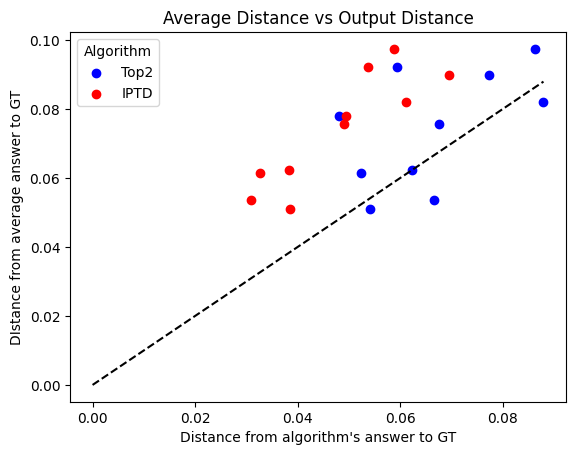

In [137]:
import matplotlib.pyplot as plt

# Create a color map for the algorithms
color_map = {'Top2': 'blue',  'IPTD': 'red'}

# Plot each algorithm with its own color
for algorithm in results_df['Algorithm'].unique():
    subset = results_df[results_df['Algorithm'] == algorithm]
    plt.scatter( subset['ChosenDistance'],subset['AverageDistance'], color=color_map[algorithm], label=algorithm)

# Set axes limits
max_x_value = results_df['ChosenDistance'].max()
# Adding a diagonal line from (0,0) to (1,1)
plt.plot([0,max_x_value], [0,max_x_value], 'k--')  # 'k--' indicates a black dashed line

# Add labels and legend
plt.xlabel("Distance from algorithm's answer to GT")
plt.ylabel("DIstance from average answer to GT")
plt.title('Average Distance vs Output Distance')
plt.legend(title='Algorithm')

# Show the plot
plt.show()


In [138]:
# Calculate correlation for each algorithm
for algorithm in results_df['Algorithm'].unique():
    subset = results_df[results_df['Algorithm'] == algorithm]
    correlation = subset['AverageDistance'].corr(subset['ChosenDistance'])
    print(f'Correlation between Average answer Distance and Chosen answer Distance for {algorithm}: {correlation}')


Correlation between Average answer Distance and Chosen answer Distance for Top2: 0.5446209537425631
Correlation between Average answer Distance and Chosen answer Distance for IPTD: 0.8793870105228901


In [139]:
def calculate_average_dist(data, distance_func):
    num_rows = data.shape[0]
    distances = np.zeros((num_rows, num_rows))

    # Calculate distances
    for i in range(num_rows):
        for j in range(num_rows):
            if i != j:
                distances[i, j] = distance_func(data.iloc[i].values, data.iloc[j].values)
# Ignoring self-distance
    # Calculate average distances
    sum_distances = np.nansum(distances, axis=1)
    average_distances = sum_distances / (num_rows - 1)

    return average_distances


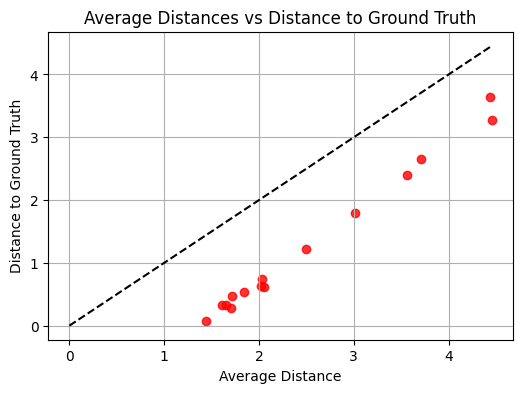

In [140]:
import matplotlib.pyplot as plt

row_indices = np.random.choice(full_dataset.shape[0], size=n, replace=False)
column_indices = np.random.choice(full_dataset.shape[1], size=k, replace=False)
data = full_dataset.iloc[row_indices, :].iloc[:, column_indices]
gt = full_dataset_gt[column_indices]
distance_func = ProxyDistanceFunctions.get_function(config.get('pairwise_distance_function', 'square_euclidean'))
average_distances = calculate_average_dist(data,distance_func)
distance_to_gt = [distance_func(data.iloc[i], gt)for i in range(len(data))]



# Plotting
plt.figure(figsize=(6, 4))
# Set axes limits
max_x_value = average_distances.max()
# Adding a diagonal line from (0,0) to (1,1)
plt.plot([0,max_x_value], [0,max_x_value], 'k--') 
plt.scatter(average_distances, distance_to_gt, color='red', alpha=0.8)
plt.ylabel('Distance to Ground Truth')
plt.xlabel('Average Distance')
plt.title('Average Distances vs Distance to Ground Truth')
plt.grid(True)
plt.show()